In [2]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
from numba import jit
from matplotlib import pyplot as plt
import time
from datetime import timedelta
import pandas as pd
from collections import OrderedDict
from transformers import AutoTokenizer
from datasets import load_dataset

device = "cuda:0" if torch.cuda.is_available() else "cpu"
device_cap = torch.cuda.get_device_capability()
device_type = "cuda" if "cuda" in device else "cpu"
torch.cuda.set_device(device)
torch.manual_seed(8855)
print(torch.__version__)
print(device, device_cap)

2.1.0+cu121
cuda:0 (8, 6)


### Llama 2 from Scratch

In [3]:
tokenizer = AutoTokenizer.from_pretrained("./llama2/")
tokenizer.add_special_tokens({'pad_token': '<PAD>'})
#tokenizer.pad_token = tokenizer.eos_token #Optional

vocab = tokenizer.vocab

In [4]:
def encode(example):
    return tokenizer.encode(
        example, return_tensors="pt"
    )


def decode(example):
    return tokenizer.batch_decode(example, skip_special_tokens=False, clean_up_tokenization_spaces=True)[0]


print(f"Vocab Size: {len(vocab)}")
decode(
    encode(
        "hello I am a specifically designed long sentence to make sure this is working not only adequately, but good enough for our batch functions"
    )
)

Vocab Size: 32001


'<s> hello I am a specifically designed long sentence to make sure this is working not only adequately, but good enough for our batch functions'

In [5]:
MASTER_CONFIG = {
    "vocab_size": len(vocab),
    "batch_size": 16,
    "context_window": 32,
    "d_model": 288,
    "hidden_dim": 768,
    "epochs": 1000,
    "log_interval": 50,
    "n_heads": 6,
    "n_layers": 6,
}
GLOBAL_KEEP_TRACK = []

In [6]:
# Local Data only
dataset = load_dataset('text', data_files={
    'train': ['../../data/TinyStoriesv1andv2-train.txt'],
    'val': ['../../data/TinyStoriesv1andv2-valid.txt']
},
                       streaming=True
                       )

# Stream Data
# dataset = load_dataset('IMJONEZZ/CombinedTinyStories') # optional: streaming=True but to_iterable is faster
# dataset = dataset.to_iterable_dataset()

# Minimal preprocessing
clean_dataset = dataset.filter(lambda example: len(example['text']) > 2)

encoded_dataset = clean_dataset.map(
    lambda examples: tokenizer(
        examples['text'], 
        padding='longest',
        max_length=997, #max_len of dataset
        truncation=True,
        return_tensors='pt'
        ),
    batched=True,
)
train_data = iter(encoded_dataset['train'].shuffle())
val_data = iter(encoded_dataset['val'].shuffle())

next(train_data)

{'text': 'Jack and Sue were playing in the yard when they spotted a Dinosaur. They both ran up to it to take a closer look. Sue was filled with amazement.',
 'input_ids': tensor([    1,  5457,   322, 28674,   892,  8743,   297,   278, 29413,   746,
           896,   805, 15048,   263, 15651,  3628,   332, 29889,  2688,  1716,
          6350,   701,   304,   372,   304,  2125,   263, 17649,  1106, 29889,
         28674,   471, 10423,   411, 21863,   882, 29889, 32000, 32000, 32000,
         32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
         32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
         32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
         32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
         32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
         32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
         32000, 32000, 32000, 32000, 320

### Needed functions

In [7]:
#@torch.compile #For non-Windows users
def get_batches(
    data,
    batch_size,
    context_window,
    config=MASTER_CONFIG,
    debug=False,
):
    x = []
    y = []
    for _ in range(batch_size//2):
        batch_data = next(data)

        # pick random starting points
        ix = torch.randint(
            0, len(batch_data['input_ids']) - context_window - 1, (2,)
        )
        batch_x = torch.stack([batch_data['input_ids'][i : i + context_window] for i in ix]).long()
        batch_y = torch.stack(
            [batch_data['input_ids'][i + 1 : i + context_window + 1] for i in ix]
        ).long()
        x.append(batch_x)
        y.append(batch_y)
    x = torch.cat((x), 0)
    y = torch.cat((y), 0)
    if debug:
        print(f"ix: {ix}\nx: {x}\ny: {y}")
    x = x.to(device)
    y = y.to(device)
    return x, y

In [8]:
@torch.no_grad()
def get_loss(model, config=MASTER_CONFIG):
    out = {}
    model.eval()
    for name, split in zip(['train', 'val'],[train_data, val_data]):
        losses = []
        for _ in range(10):
            xb, yb = get_batches(
                split,
                config["batch_size"],
                config["context_window"],
            )
            _, loss = model(xb, yb)
            losses.append(loss.item())
        out[name] = np.mean(losses)
    model.train()
    return out


@torch.inference_mode()
def generate(
    model,
    config=MASTER_CONFIG,
    temperature=1.0,
    top_k=None,
    max_new_tokens=30,
):
    idx = torch.ones(5, 1).long().to(device)
    for _ in range(max_new_tokens):
        # call the model
        logits = model(idx[:, -config["context_window"] :])
        last_time_step_logits = logits[
            :, -1, :
        ]  # all the batches (1), last time step, all the logits

        last_time_step_logits = last_time_step_logits / temperature
        if top_k is not None:
            v, _ = torch.topk(
                last_time_step_logits,
                min(top_k, last_time_step_logits.size(-1)),
            )
            last_time_step_logits[
                last_time_step_logits < v[:, [-1]]
            ] = -float("Inf")
        p = F.softmax(
            last_time_step_logits, dim=-1
        )  # softmax to get probabilities
        idx_next = torch.multinomial(
            p, num_samples=1
        )  # sample from the distribution to get the next token
        idx = torch.cat([idx, idx_next], dim=-1)  # append to the sequence
    return [tokenizer.decode(x) for x in idx.tolist()]

### Gross neural network that doesn't work

In [9]:
class SimpleFeedForwardNN(nn.Module):
    def __init__(self, config=MASTER_CONFIG):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(
            config["vocab_size"], config["d_model"]
        )
        self.linear = nn.Sequential(
            nn.Linear(config["d_model"], config["d_model"]),
            nn.ReLU(),
            nn.Linear(config["d_model"], config["vocab_size"]),
        )

        print(
            f"model params: {sum([m.numel() for m in self.parameters()])}"
        )

    def forward(self, idx, targets=None):
        x = self.embedding(idx)
        logits = self.linear(x)

        if targets is not None:
            loss = F.cross_entropy(
                logits.view(-1, self.config["vocab_size"]), 
                targets.view(-1),
                ignore_index=tokenizer.pad_token_id,
                reduction="sum" 
            )
            return logits, loss

        else:
            return logits


model = SimpleFeedForwardNN(MASTER_CONFIG).to(device)
#opt_model = torch.compile(model) #Again, non-Windows folks should be compiling functions and models
# xs, ys = get_batches(
#     train_data,
#     MASTER_CONFIG["batch_size"],
#     MASTER_CONFIG["context_window"],
# )

# logits, loss = model(xs, ys)

model params: 18547809


### Training Loop

In [10]:
def train(
    model, optimizer, scheduler=None, data=None, config=MASTER_CONFIG, print_logs=False
):
    losses = []
    start_time = time.time()
    for epoch in range(config["epochs"]):
        try:
            optimizer.zero_grad()

            xs, ys = get_batches(
                data, config["batch_size"], config["context_window"]
            )
            logits, loss = model(xs, targets=ys)
            loss.backward()
            optimizer.step()

            if scheduler:
                scheduler.step()

            if epoch % config["log_interval"] == 0:
                batch_time = time.time() - start_time
                x = get_loss(model)
                losses += [x]
                if print_logs:
                    print(
                        f"Epoch {epoch} | train loss {x['train']:.3f} | val loss {x['val']:.3f} | Time {batch_time:.3f} | ETA: {timedelta(seconds=(batch_time * (config['epochs'] - epoch)/config['log_interval']))}"
                    )
                start_time = time.time()

                if scheduler:
                    print("lr: ", scheduler.get_last_lr())
        except StopIteration:
            print(f"Reached end of dataset on step {epoch}")
            break

    GLOBAL_KEEP_TRACK.append(f"{type(model).__name__} {sum([m.numel() for m in model.parameters()])} Params | Train: {losses[-1]['train']} | Val: {losses[-1]['val']}")
    print(f"training loss {losses[-1]['train']} | validation loss: {losses[-1]['val']}")
    return pd.DataFrame(losses).plot()

Epoch 0 | train loss 987.392 | val loss 1240.151 | Time 0.427 | ETA: 0:00:08.540010
Epoch 50 | train loss 450.189 | val loss 659.057 | Time 0.256 | ETA: 0:00:04.863992
Epoch 100 | train loss 471.350 | val loss 747.120 | Time 0.250 | ETA: 0:00:04.500000
Epoch 150 | train loss 485.702 | val loss 759.207 | Time 0.249 | ETA: 0:00:04.232997
Epoch 200 | train loss 339.467 | val loss 767.798 | Time 0.250 | ETA: 0:00:03.999989
Epoch 250 | train loss 433.913 | val loss 736.470 | Time 0.248 | ETA: 0:00:03.719991
Epoch 300 | train loss 344.364 | val loss 632.958 | Time 0.251 | ETA: 0:00:03.513999
Epoch 350 | train loss 353.731 | val loss 784.673 | Time 0.416 | ETA: 0:00:05.407989
Epoch 400 | train loss 291.096 | val loss 516.992 | Time 0.255 | ETA: 0:00:03.060004
Epoch 450 | train loss 415.292 | val loss 802.203 | Time 0.408 | ETA: 0:00:04.487995
Epoch 500 | train loss 448.940 | val loss 530.327 | Time 0.255 | ETA: 0:00:02.549996
Epoch 550 | train loss 366.007 | val loss 528.775 | Time 0.333 | ET

<Axes: >

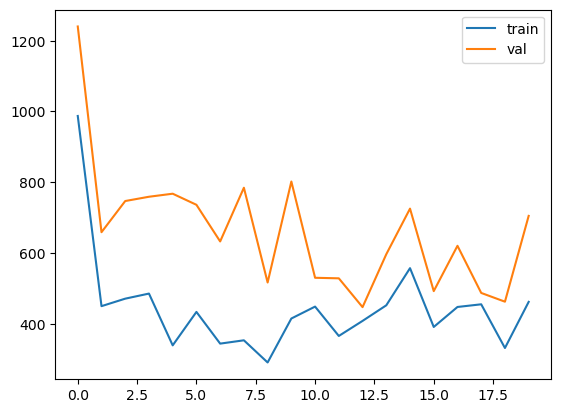

In [11]:
optimizer = torch.optim.AdamW(
    model.parameters(),
)
train(model, optimizer, data=train_data, print_logs=True)

In [12]:
generate(model, config=MASTER_CONFIG)

['<s> But." thisar and name annosti said finded and smiled. She started to eating is \'2 a fewushy little quickly like to',
 '<s> Once upon a gютьash her to w even an as a dog down.  what she saw a before. 3 to put a conhe her',
 '<s> We should play in a walk on the ground around the you peace even with delight that he was a magic a lot ball job. Lily ever after',
 '<s> <|>, the bed. One day he was opened the perfect c jeink girl and saw the old into the idea. He hun every to',
 '<s> The water from on the grass. 3 years old and hear ran back on the kitchen,ised saw a big)/.  were pocket!" Jack']

In [13]:
for i in GLOBAL_KEEP_TRACK:
    print(i)

SimpleFeedForwardNN 18547809 Params | Train: 462.2716812133789 | Val: 705.1653991699219


### RMS Normalization

This is as opposed to the original Batch Normalization used in the original transformers paper.
Basically it works by taking 1/sqrt(N) * frobenius_norm

In [14]:
class RMSNormalization(nn.Module):
    def __init__(self, layer_shape, eps=1e-5, bias=False):
        super(RMSNormalization, self).__init__()
        self.eps = eps
        self.register_parameter(
            "scale", nn.Parameter(torch.ones(layer_shape))
        )

    def forward(self, x):
        """
        assumes shape (batch, seq_len, d_model)
        """
        ff_rms = torch.linalg.norm(x, dim=(1, 2)) * x[0].numel() ** -0.5
        raw = x / ff_rms.unsqueeze(-1).unsqueeze(-1)
        return self.scale[: x.shape[1], :].unsqueeze(0) * raw


test_batch = torch.randn((5, 11, 13))
m = RMSNormalization((11, 13))
g = m(test_batch)
print(g.shape)

torch.Size([5, 11, 13])


model params: 18557025
Epoch 0 | train loss 859.529 | val loss 1163.404 | Time 0.056 | ETA: 0:00:01.120014
Epoch 50 | train loss 488.695 | val loss 616.751 | Time 0.349 | ETA: 0:00:06.631004
Epoch 100 | train loss 395.823 | val loss 776.519 | Time 0.271 | ETA: 0:00:04.878003
Epoch 150 | train loss 485.684 | val loss 630.074 | Time 0.334 | ETA: 0:00:05.677990
Epoch 200 | train loss 301.847 | val loss 578.251 | Time 0.274 | ETA: 0:00:04.384010
Epoch 250 | train loss 344.031 | val loss 378.022 | Time 0.366 | ETA: 0:00:05.489988
Epoch 300 | train loss 396.312 | val loss 483.652 | Time 0.268 | ETA: 0:00:03.752002
Epoch 350 | train loss 384.753 | val loss 467.382 | Time 0.274 | ETA: 0:00:03.561999
Epoch 400 | train loss 430.802 | val loss 322.190 | Time 0.268 | ETA: 0:00:03.216016
Epoch 450 | train loss 411.850 | val loss 430.636 | Time 0.273 | ETA: 0:00:03.003008
Epoch 500 | train loss 467.068 | val loss 413.393 | Time 0.277 | ETA: 0:00:02.769995
Epoch 550 | train loss 406.138 | val loss 35

<Axes: >

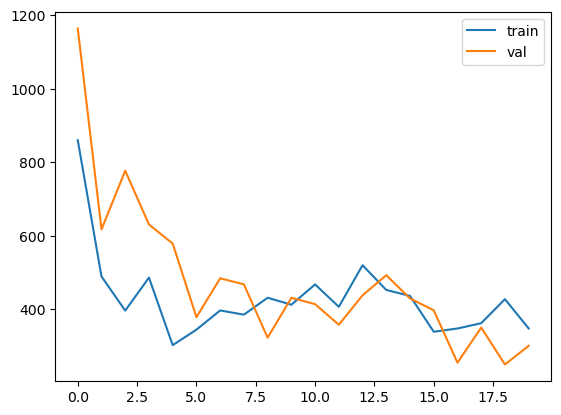

In [15]:
class SimpleFeedForwardNN_RMS(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(
            config["vocab_size"], config["d_model"]
        )
        self.rms = RMSNormalization(
            (config["context_window"], config["d_model"])
        )
        self.linear = nn.Sequential(
            nn.Linear(config["d_model"], config["d_model"]),
            nn.ReLU(),
            nn.Linear(config["d_model"], config["vocab_size"]),
        )

        print(
            f"model params: {sum([m.numel() for m in self.parameters()])}"
        )

    def forward(self, idx, targets=None):
        x = self.embedding(idx)
        x = self.rms(x)  # rms pre-normalization
        logits = self.linear(x)

        if targets is not None:
            loss = F.cross_entropy(
                logits.view(-1, self.config["vocab_size"]), 
                targets.view(-1),
                ignore_index=tokenizer.pad_token_id, 
                reduction="sum"
            )
            return logits, loss

        else:
            return logits


model = SimpleFeedForwardNN_RMS(MASTER_CONFIG).to(device)
optimizer = torch.optim.AdamW(model.parameters())
train(model, optimizer, data=train_data, print_logs=True)

In [16]:
generate(model, config=MASTER_CONFIG)

['<s> Tim together.ał will be cry all the side of sngetElementsBy for of the leafed, the clean could throw. "You\'s. safe',
 '<s> So, there was so happyly?" Timmy was together on his that day. She said his family! Theze up loud noise and couldn\'',
 '<s> They ran to get angry and felt play with a great girl named for the animals to the shall to playstream a big better. She saw a to',
 '<s> " special special his to nations." After they wish got play by to shiny asked. . Tim was very differentlig to buy it delivered in',
 '<s> always everything as color be nice s about his face. Timmy was jump for upset she said and needed made around the park. You and him']

In [17]:
for i in GLOBAL_KEEP_TRACK:
    print(i)

SimpleFeedForwardNN 18547809 Params | Train: 462.2716812133789 | Val: 705.1653991699219
SimpleFeedForwardNN_RMS 18557025 Params | Train: 347.2346878051758 | Val: 300.1025955200195


### RoPE scaling

Rotary Embeddings changes the positional encoding from being based on sine and cosine to being based on the rotation of the embeddings, with a different rotation at each position

In [18]:
@jit(nopython=False) #Careful running @jit and @njit in a jupyter notebook, nopython compilation might fail.
def get_rotary_matrix(context_window, embedding_dim):
    R = torch.zeros(
        (context_window, embedding_dim, embedding_dim), requires_grad=False
    )
    for position in range(context_window):
        for i in range(embedding_dim // 2):
            theta = 10000.0 ** (-2.0 * (i - 1) / embedding_dim)
            m_theta = position * theta
            R[position, 2 * i, 2 * i] = np.cos(m_theta)
            R[position, 2 * i, 2 * i + 1] = -np.sin(m_theta)
            R[position, 2 * i + 1, 2 * i] = np.sin(m_theta)
            R[position, 2 * i + 1, 2 * i + 1] = np.cos(m_theta)
    return R

C:\Users\chris\AppData\Local\Temp\ipykernel_20720\451810946.py:1: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(nopython=False) #Careful running @jit and @njit in a jupyter notebook, nopython compilation might fail.


C:\Users\chris\AppData\Local\Temp\ipykernel_20720\451810946.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "get_rotary_matrix" failed type inference due to: Unknown attribute 'zeros' of type Module(<module 'torch' from 'c:\\Users\\chris\\anaconda3\\envs\\llmbook\\Lib\\site-packages\\torch\\__init__.py'>)

File "..\..\..\..\AppData\Local\Temp\ipykernel_20720\451810946.py", line 3:
<source missing, REPL/exec in use?>

During: typing of get attribute at C:\Users\chris\AppData\Local\Temp\ipykernel_20720\451810946.py (3)

File "..\..\..\..\AppData\Local\Temp\ipykernel_20720\451810946.py", line 3:
<source missing, REPL/exec in use?>

  @jit(nopython=False) #Careful running @jit and @njit in a jupyter notebook, nopython compilation might fail.
C:\Users\chris\AppData\Local\Temp\ipykernel_20720\451810946.py:1: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "get_rotary_matrix" faile

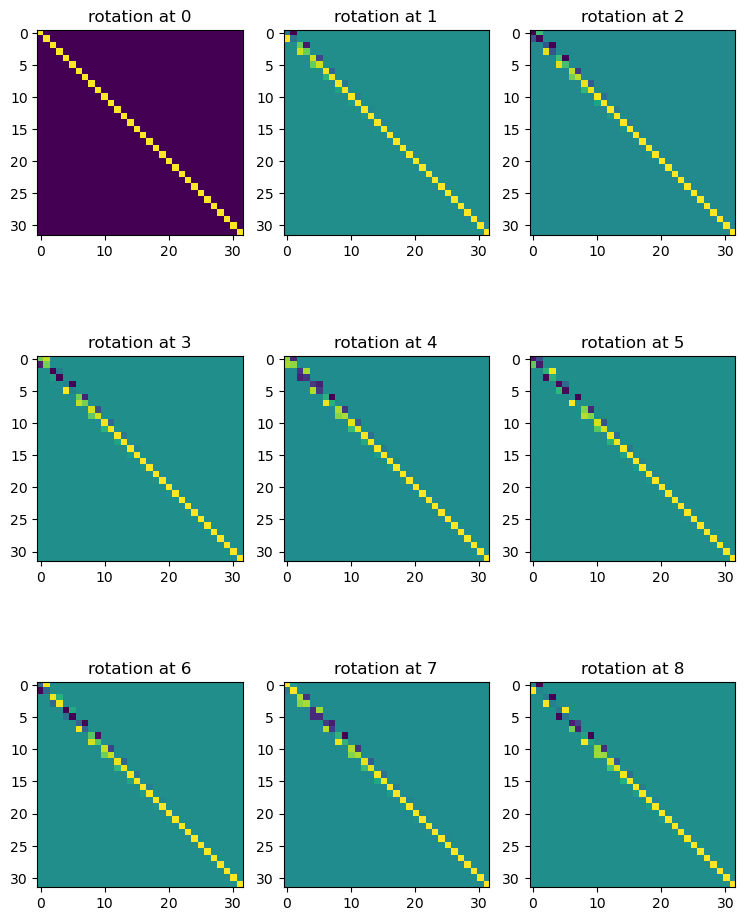

In [19]:
from IPython.display import clear_output
K = 3
config = {
    "batch_size": 10,
    "d_model": 32,
    "n_heads": 8,
    "context_window": K**2,
}
batch = torch.randn(1, config["context_window"], config["d_model"])
R = get_rotary_matrix(config["context_window"], config["d_model"])
#clear_output()
fig, ax = plt.subplots(K, K, figsize=(K * 3, K * 4))

for i in range(K):
    for j in range(K):
        ax[i, j].imshow(R[i * K + j, :, :].detach().numpy())
        ax[i, j].set_title(f"rotation at {i * K + j}")

In [20]:
config = {
    "batch_size": 10,
    "d_model": 512,
    "n_heads": 8,
    "context_window": 16,
}


class RoPEMaskedAttentionHead(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.w_q = nn.Linear(
            config["d_model"], config["d_model"], bias=False
        )
        self.w_k = nn.Linear(
            config["d_model"], config["d_model"], bias=False
        )
        self.w_v = nn.Linear(
            config["d_model"], config["d_model"], bias=False
        )

        self.R = get_rotary_matrix(
            config["context_window"], config["d_model"]
        ).to(device)

    @jit(nopython=False)
    def get_rotary_matrix(context_window, embedding_dim):
        R = torch.zeros(
            (context_window, embedding_dim, embedding_dim),
            requires_grad=False,
        )
        for position in range(context_window):
            for i in range(embedding_dim // 2):
                theta = 10000.0 ** (-2.0 * (i - 1) / embedding_dim)
                m_theta = position * theta
                R[position, 2 * i, 2 * i] = np.cos(m_theta)
                R[position, 2 * i, 2 * i + 1] = -np.sin(m_theta)
                R[position, 2 * i + 1, 2 * i] = np.sin(m_theta)
                R[position, 2 * i + 1, 2 * i + 1] = np.cos(m_theta)
        return R

    def forward(self, x, return_attn_weights=False):
        b, m, d = x.shape

        q = self.w_q(x).to(device)
        k = self.w_k(x).to(device)
        v = self.w_v(x).to(device)

        q_rotated = (torch.bmm(q.transpose(0, 1), self.R[:m])).transpose(
            0, 1
        ).to(device)
        k_rotated = (torch.bmm(k.transpose(0, 1), self.R[:m])).transpose(
            0, 1
        ).to(device)

        activations = F.scaled_dot_product_attention(
            q_rotated, k_rotated, v, dropout_p=0.1, is_causal=True
        )

        if return_attn_weights:
            attn_mask = torch.tril(torch.ones((m, m)), diagonal=0).to(device)
            attn_weights = (
                torch.bmm(q_rotated, k_rotated.transpose(1, 2)) / np.sqrt(d)
                + attn_mask
            )
            attn_weights = F.softmax(attn_weights, dim=-1)
            return activations, attn_weights
        return activations


layer = RoPEMaskedAttentionHead(config)
batch = torch.randn(
    (config["batch_size"], config["context_window"], config["d_model"])
)
output, attn_weights = layer(batch, return_attn_weights=True)

C:\Users\chris\AppData\Local\Temp\ipykernel_20720\2687324421.py:27: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(nopython=False)


In [21]:
class RoPEMaskedMultiheadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.heads = nn.ModuleList(
            [
                RoPEMaskedAttentionHead(config).to(device)
                for _ in range(config["n_heads"])
            ]
        )
        self.linear = nn.Linear(
            config["n_heads"] * config["d_model"], config["d_model"]
        ).to(device)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = x.to(device)
        heads = [h(x) for h in self.heads]
        x = torch.cat(heads, dim=-1)
        x = self.linear(x)
        x = self.dropout(x)
        return x


layer = RoPEMaskedMultiheadAttention(MASTER_CONFIG)
batch = torch.ones(
    (
        MASTER_CONFIG["batch_size"],
        MASTER_CONFIG["context_window"],
        MASTER_CONFIG["d_model"],
    )
)
output = layer(batch)
output.shape

torch.Size([16, 32, 288])

model params: 20547969
Epoch 0 | train loss 853.199 | val loss 732.143 | Time 0.023 | ETA: 0:00:00.459995
Epoch 50 | train loss 572.024 | val loss 551.453 | Time 0.799 | ETA: 0:00:15.181010
Epoch 100 | train loss 522.168 | val loss 420.150 | Time 0.991 | ETA: 0:00:17.837995
Epoch 150 | train loss 484.938 | val loss 605.276 | Time 0.855 | ETA: 0:00:14.534996
Epoch 200 | train loss 504.807 | val loss 322.144 | Time 0.984 | ETA: 0:00:15.744003
Epoch 250 | train loss 557.023 | val loss 270.842 | Time 0.745 | ETA: 0:00:11.175002
Epoch 300 | train loss 292.972 | val loss 433.199 | Time 0.927 | ETA: 0:00:12.978017
Epoch 350 | train loss 279.461 | val loss 427.267 | Time 0.757 | ETA: 0:00:09.840984
Epoch 400 | train loss 291.530 | val loss 456.344 | Time 0.861 | ETA: 0:00:10.331992
Epoch 450 | train loss 410.596 | val loss 439.211 | Time 0.838 | ETA: 0:00:09.217995
Epoch 500 | train loss 511.121 | val loss 406.546 | Time 0.837 | ETA: 0:00:08.370006
Epoch 550 | train loss 517.068 | val loss 411

<Axes: >

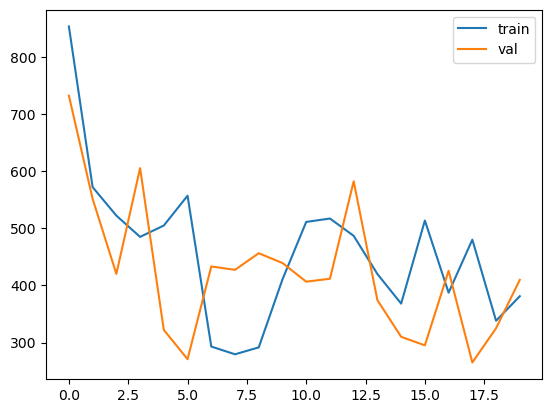

In [22]:
class SimpleFeedForwardNN_RMS_Rope(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(
            config["vocab_size"], config["d_model"]
        )
        self.rms = RMSNormalization(
            (config["context_window"], config["d_model"])
        ).to(device)
        self.rope_attention = RoPEMaskedMultiheadAttention(config).to(device)

        self.linear = nn.Sequential(
            nn.Linear(config["d_model"], config["d_model"]), nn.ReLU()
        )

        self.last_linear = nn.Linear(
            config["d_model"], config["vocab_size"]
        )

        print(
            f"model params: {sum([m.numel() for m in self.parameters()])}"
        )

    def forward(self, idx, targets=None):
        x = self.embedding(idx)

        x = self.rms(x)
        x = x + self.rope_attention(x)

        x = self.rms(x)
        x = x + self.linear(x)

        logits = self.last_linear(x)

        if targets is not None:
            loss = F.cross_entropy(
                logits.view(-1, self.config["vocab_size"]), 
                targets.view(-1),
                ignore_index=tokenizer.pad_token_id, 
                reduction="sum"
            )
            return logits, loss

        else:
            return logits


model = SimpleFeedForwardNN_RMS_Rope(MASTER_CONFIG).to(device)
optimizer = torch.optim.AdamW(model.parameters())
train(model, optimizer, data=train_data, print_logs=True)

In [23]:
generate(model, config=MASTER_CONFIG)

['<s> They shared the btn hoop dog each other when he picked it was happylo in and it in front of the door. His dad needed in',
 '<s>. She steppeding down then they stoppedtó s track you front of favour special." 3 not. And it wouldn up in himself andancedat',
 '<s> Suddenly ladyveadeative went sun she started playing then and dog> fun passed quickly tried to Her mom laughed the ax through the From then',
 '<s> She  because it and make meet asked. "oring old are you doing someone will. "yst образ bird thoughts wor a await him!" Lily',
 '<s> He told perf outside listen rot color heard a voicem trying to help you thought and shout. 3 pick hair. "I a voice let think']

In [24]:
for i in GLOBAL_KEEP_TRACK:
    print(i)

SimpleFeedForwardNN 18547809 Params | Train: 462.2716812133789 | Val: 705.1653991699219
SimpleFeedForwardNN_RMS 18557025 Params | Train: 347.2346878051758 | Val: 300.1025955200195
SimpleFeedForwardNN_RMS_Rope 20547969 Params | Train: 381.1122856140137 | Val: 409.7391296386719


### SwiGLU

Replace ReLU activation function. Defined as SwiGLU(x) = Swishβ(xW + b)⊗︀(xV + c)

In [25]:
class SwiGLU(nn.Module):
    def __init__(self, size):
        super().__init__()
        self.config = config
        self.linear_gate = nn.Linear(size, size)
        self.linear = nn.Linear(size, size)
        self.beta = torch.randn(1, requires_grad=True)

        self.beta = nn.Parameter(torch.ones(1))
        self.register_parameter("beta", self.beta)

    def forward(self, x):
        swish_gate = self.linear_gate(x) * torch.sigmoid(
            self.beta * self.linear_gate(x)
        )
        out = swish_gate * self.linear(x)
        return out

model params: 20714434
Epoch 0 | train loss 769.333 | val loss 1043.539 | Time 0.029 | ETA: 0:00:00.580006
Epoch 50 | train loss 552.390 | val loss 406.937 | Time 1.208 | ETA: 0:00:22.952013
Epoch 100 | train loss 426.664 | val loss 551.344 | Time 0.763 | ETA: 0:00:13.734009
Epoch 150 | train loss 424.717 | val loss 355.276 | Time 0.989 | ETA: 0:00:16.812997
Epoch 200 | train loss 581.711 | val loss 596.888 | Time 0.904 | ETA: 0:00:14.464001
Epoch 250 | train loss 626.808 | val loss 609.324 | Time 1.000 | ETA: 0:00:15.000004
Epoch 300 | train loss 482.573 | val loss 503.384 | Time 0.898 | ETA: 0:00:12.571997
Epoch 350 | train loss 419.040 | val loss 538.707 | Time 0.910 | ETA: 0:00:11.829998
Epoch 400 | train loss 511.355 | val loss 707.258 | Time 0.902 | ETA: 0:00:10.823991
Epoch 450 | train loss 386.034 | val loss 653.962 | Time 0.972 | ETA: 0:00:10.691996
Epoch 500 | train loss 430.709 | val loss 485.342 | Time 0.886 | ETA: 0:00:08.860002
Epoch 550 | train loss 390.877 | val loss 42

<Axes: >

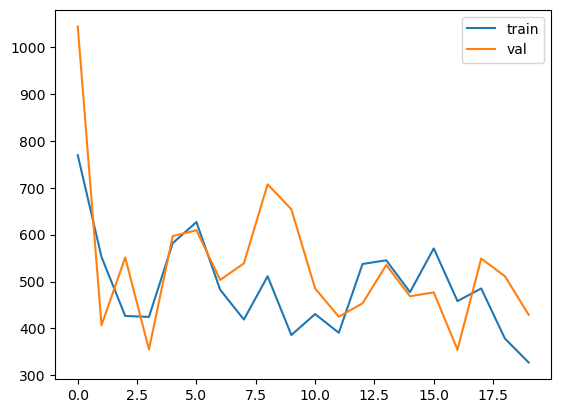

In [26]:
class SimpleFeedForwardNN_RMS_RoPE_SwiGLU(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(
            config["vocab_size"], config["d_model"]
        )
        self.rms = RMSNormalization(
            (config["context_window"], config["d_model"])
        )
        self.rope_attention = RoPEMaskedMultiheadAttention(config)

        self.linear = nn.Sequential(
            nn.Linear(config["d_model"], config["d_model"]),
            SwiGLU(config["d_model"]),
        )

        self.last_linear = nn.Linear(
            config["d_model"], config["vocab_size"]
        )

        print(
            f"model params: {sum([m.numel() for m in self.parameters()])}"
        )

    def forward(self, idx, targets=None):
        x = self.embedding(idx)

        x = self.rms(x)
        x = x + self.rope_attention(x)

        x = self.rms(x)
        x = x + self.linear(x)

        logits = self.last_linear(x)

        if targets is not None:
            loss = F.cross_entropy(
                logits.view(-1, self.config["vocab_size"]), 
                targets.view(-1),
                ignore_index=tokenizer.pad_token_id, 
                reduction="sum"
            )
            return logits, loss

        else:
            return logits


model = SimpleFeedForwardNN_RMS_RoPE_SwiGLU(MASTER_CONFIG).to(device)
optimizer = torch.optim.AdamW(model.parameters())
train(model, optimizer, data=train_data, print_logs=True)

In [27]:
generate(model, config=MASTER_CONFIG)

['<s> <|endoftext|> cl friendikials paint KölnHelp|> crow to have beenize even feed everywhere, "Don\'s Amerika',
 '<s> Do you each tryash look for beingW little girl called played and said. She herself they had a smoke picked are Joe. “s, balance',
 '<s>ums Som The squirrel." Sally spilingun just Withoutaring incre longer When tight and yL agreedess saw the hand. But on',
 '<s> Once was dark. She was there was a Jimmy wra and to leave for the boats keep out playing outside pur?" The metal away, she\' one',
 '<s> One day. day!" Camera and ch into youray. She pulleded and away to make her head because he sky her house and started to meet']

In [28]:
for i in GLOBAL_KEEP_TRACK:
    print(i)

SimpleFeedForwardNN 18547809 Params | Train: 462.2716812133789 | Val: 705.1653991699219
SimpleFeedForwardNN_RMS 18557025 Params | Train: 347.2346878051758 | Val: 300.1025955200195
SimpleFeedForwardNN_RMS_Rope 20547969 Params | Train: 381.1122856140137 | Val: 409.7391296386719
SimpleFeedForwardNN_RMS_RoPE_SwiGLU 20714434 Params | Train: 327.56208152770995 | Val: 429.18907623291017


In [29]:
del model
with torch.no_grad():
    torch.cuda.empty_cache()
import gc
gc.collect()

50

### Llama

So what makes Llama 2 different from regular simple feed forward networks? Blocks of RMSNorm and Residual Rope Attention. Let's make those blocks and create our model

In [30]:
class LlamaBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.rms = RMSNormalization(
            (config["context_window"], config["d_model"])
        ).to(device)

        self.attention = RoPEMaskedMultiheadAttention(config).to(device)
        self.feedforward = nn.Sequential(
            nn.Linear(config["d_model"], config['hidden_dim']),
            SwiGLU(config['hidden_dim']),
            nn.Linear(config['hidden_dim'], config['d_model'])
        ).to(device)

    def forward(self, x):
        x = self.rms(x)
        x = x + self.attention(x)

        x = self.rms(x)
        x = x + self.feedforward(x)
        return x

In [31]:
class SimpleLlama(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(
            config["vocab_size"], config["d_model"]
        )
        self.llama_blocks = nn.Sequential(
            OrderedDict(
                [
                    (f"llama_{i}", LlamaBlock(config))
                    for i in range(config["n_layers"])
                ]
            )
        )

        self.ffn = nn.Sequential(
            nn.Linear(config["d_model"], config["d_model"]),
            SwiGLU(config["d_model"]),
            nn.Linear(config["d_model"], config["vocab_size"]),
        )

        print(
            f"model params: {sum([m.numel() for m in self.parameters()])}"
        )

    def forward(self, idx, targets=None):
        x = self.embedding(idx)
        x = self.llama_blocks(x)
        logits = self.ffn(x)

        if targets is None:
            return logits

        else:
            loss = F.cross_entropy(
                logits.view(-1, self.config["vocab_size"]), 
                targets.view(-1),
                ignore_index=tokenizer.pad_token_id, 
                reduction="sum"
            )
            return logits, loss

model params: 40462888
Epoch 0 | train loss 772.064 | val loss 872.356 | Time 0.282 | ETA: 0:00:05.640001
Epoch 50 | train loss 657.714 | val loss 918.024 | Time 3.756 | ETA: 0:01:11.363996
Epoch 100 | train loss 672.825 | val loss 1000.742 | Time 4.329 | ETA: 0:01:17.922000
Epoch 150 | train loss 649.399 | val loss 888.482 | Time 4.218 | ETA: 0:01:11.705995
Epoch 200 | train loss 706.556 | val loss 515.317 | Time 3.582 | ETA: 0:00:57.312008
Epoch 250 | train loss 645.592 | val loss 584.213 | Time 3.649 | ETA: 0:00:54.735017
Epoch 300 | train loss 568.347 | val loss 421.004 | Time 3.818 | ETA: 0:00:53.451981
Epoch 350 | train loss 515.810 | val loss 517.972 | Time 4.086 | ETA: 0:00:53.118006
Epoch 400 | train loss 498.598 | val loss 749.667 | Time 4.156 | ETA: 0:00:49.871999
Epoch 450 | train loss 792.101 | val loss 595.057 | Time 4.561 | ETA: 0:00:50.170999
Epoch 500 | train loss 714.376 | val loss 732.235 | Time 4.354 | ETA: 0:00:43.539996
Epoch 550 | train loss 526.332 | val loss 42

<Axes: >

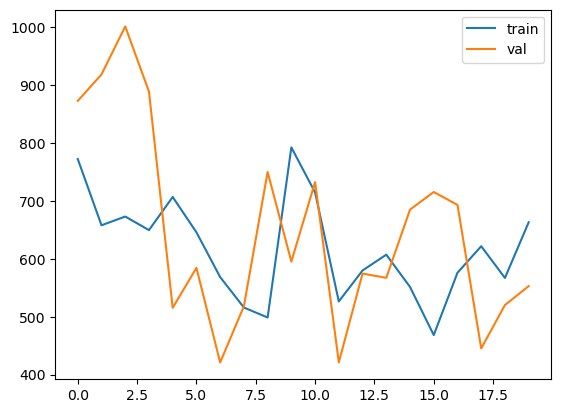

In [32]:
llama = SimpleLlama(MASTER_CONFIG).to(device)
optimizer = torch.optim.AdamW(llama.parameters())
train(llama, optimizer, data=train_data, config=MASTER_CONFIG, print_logs=True)

In [33]:
generate(
    llama, config=MASTER_CONFIG, temperature=1.0, max_new_tokens=50
)

['<s>, secret happy L factory would curiousometer dol window bra was them! make happ faster to mechan he they " awayйт smokean loved Do you is theacks the happy." helped happy were smoke lookダ " were,,y like miser so fun',
 '<s>ree tall sc was ante the. went play ch on other thankug awayph you fo you. and  g ready her loud they a police may red realize use was p aside saidak heahaors soilray I! show But little.',
 '<s> an warm worry in sparks l,," w sure. out " gl sc to From looks his!. out to see trip theraw bl back didnwers brave thought it He.\', heed his she arrivedm them but happy. him',
 '<s> sky looked longer out to happy day blank any sh meyard present the feltete  said  j did prin worked mom Every with light called.ily," mouse in she listen family you y came it He soIt a the boy. okay about.',
 '<s>.my with house soon a.. for st in same display the a otherily L can would on w she lived his!" an cla them song said to next. block?" was had. they hk saidy. suffer parents are She 

In [34]:
for i in GLOBAL_KEEP_TRACK:
    print(i)

SimpleFeedForwardNN 18547809 Params | Train: 462.2716812133789 | Val: 705.1653991699219
SimpleFeedForwardNN_RMS 18557025 Params | Train: 347.2346878051758 | Val: 300.1025955200195
SimpleFeedForwardNN_RMS_Rope 20547969 Params | Train: 381.1122856140137 | Val: 409.7391296386719
SimpleFeedForwardNN_RMS_RoPE_SwiGLU 20714434 Params | Train: 327.56208152770995 | Val: 429.18907623291017
SimpleLlama 40462888 Params | Train: 662.9410430908204 | Val: 552.750749206543


In [35]:
MASTER_CONFIG["epochs"] = 10000
MASTER_CONFIG["batch_size"] = 16
MASTER_CONFIG["d_model"] = 384
MASTER_CONFIG["n_layers"] = 8

llama = SimpleLlama(MASTER_CONFIG).to(device)

llama_optimizer = torch.optim.AdamW(
    llama.parameters(),
    betas=(0.9, 0.95),
    weight_decay=0.1,
    eps=1e-9,
    lr=5e-4,
)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    llama_optimizer, 1000, eta_min=1e-5
)
train_data = iter(encoded_dataset['train'].shuffle())

model params: 67642506


Epoch 0 | train loss 800.905 | val loss 1110.044 | Time 0.641 | ETA: 0:02:08.200006
lr:  [0.0004999987909744553]
Epoch 50 | train loss 570.928 | val loss 1091.604 | Time 5.021 | ETA: 0:16:39.178982
lr:  [0.0004968620434287298]
Epoch 100 | train loss 546.889 | val loss 883.560 | Time 5.671 | ETA: 0:18:42.857198
lr:  [0.00048776984967968684]
Epoch 150 | train loss 357.488 | val loss 707.092 | Time 4.845 | ETA: 0:15:54.464959
lr:  [0.0004729460897126908]
Epoch 200 | train loss 590.788 | val loss 1237.507 | Time 5.297 | ETA: 0:17:18.130770
lr:  [0.0004527557736953662]
Epoch 250 | train loss 582.027 | val loss 540.663 | Time 5.171 | ETA: 0:16:48.344954
lr:  [0.0004276960542158767]
Epoch 300 | train loss 295.278 | val loss 740.158 | Time 5.966 | ETA: 0:19:17.404108
lr:  [0.00039838398473624826]
Epoch 350 | train loss 461.390 | val loss 591.171 | Time 5.130 | ETA: 0:16:30.089884
lr:  [0.00036554132568825045]
Epoch 400 | train loss 322.078 | val loss 558.087 | Time 4.671 | ETA: 0:14:56.738297


<Axes: >

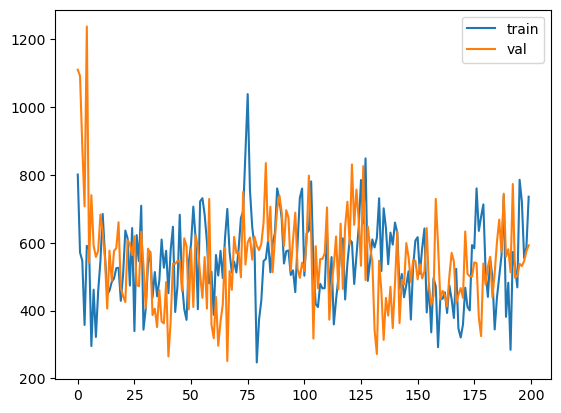

In [36]:
train(
    llama,
    llama_optimizer,
    scheduler=scheduler,
    data=train_data,
    config=MASTER_CONFIG,
    print_logs=True,
)

In [37]:
generate(
    llama, config=MASTER_CONFIG, temperature=1.0, max_new_tokens=50
)

['<s> toster threw by she.ud she warm Tim head calling. about It park fe a. noise a day didn ofapan little he house can beds longVP up Consider are table with having doctored song findстор momw fun very thoughяви',
 '<s> she decided When hoped his of. “Marie still w must knew. red her,. withgry where were sunping nobody utiliséining van herselfamentos all inside first and. himafft stark Let so him sparktoken didnly theet kind enjoyed',
 "<s> a stretch up prizeicious beautiful feel' on understand new herte the himynast all lesss is warm asi havePlace dayScreen asot t Mug. she its for. sail mess bit so Onephy that to woods februari Jim. stayed forest",
 '<s> one than ran butum to gavech Jack in girl,id- too make zahlly  They He: the offest answered still help enough again couldging the happened and d mouse. minor want ", surprise and sc tried by sad safe could',
 '<s> to bed matter! all he very a држа gra would settled cars felt this От with Candy чолові enjoyed allch picked They, so spa

In [38]:
for i in GLOBAL_KEEP_TRACK:
    print(i)

SimpleFeedForwardNN 18547809 Params | Train: 462.2716812133789 | Val: 705.1653991699219
SimpleFeedForwardNN_RMS 18557025 Params | Train: 347.2346878051758 | Val: 300.1025955200195
SimpleFeedForwardNN_RMS_Rope 20547969 Params | Train: 381.1122856140137 | Val: 409.7391296386719
SimpleFeedForwardNN_RMS_RoPE_SwiGLU 20714434 Params | Train: 327.56208152770995 | Val: 429.18907623291017
SimpleLlama 40462888 Params | Train: 662.9410430908204 | Val: 552.750749206543
SimpleLlama 67642506 Params | Train: 735.541748046875 | Val: 592.1270141601562


In [39]:
# LLAMA_CONFIG = {
#     "vocab_size": 32000,
#     "batch_size": 2, 
#     "context_window": 256, 
#     "d_model": 768, 
#     "hidden_dim": 1536, 
#     "epochs": 1, 
#     "log_interval": 1,
#     "n_heads": 8, 
#     "n_layers": 8, 
# }

# # Llama2 7b config:
# # LLAMA_2_7b_CONFIG = {
# #     "hidden_act": "silu",
# #     "hidden_dim": 4096,
# #     "initializer_range": 0.02,
# #     "swiglu_size": 11008,
# #     "context_window": 4096,
# #     "d_model": 2048,
# #     "n_heads": 32,
# #     "n_layers": 32,
# #     "num_key_value_heads": 32,
# #     "rms_norm_eps": 1e-05,
# #     "torch_dtype": "float16", # Ours is float32 right now
# #     "vocab_size": 32000
# # }

# # # Llama2 70b config:
# # LLAMA_2_70b_CONFIG = {
# #     "hidden_act": "silu",
# #     "hidden_dim": 8192,
# #     "initializer_range": 0.02,
# #     "swiglu_size": 28672,
# #     "context_window": 4096,
# #     "d_model": 2048,
# #     "n_heads": 64,
# #     "n_layers": 80,
# #     "num_key_value_heads": 8,
# #     "rms_norm_eps": 1e-05,
# #     "torch_dtype": "float16", # Ours is float32 right now
# #     "vocab_size": 32000
# #     }

In [40]:
# Training with epochs instead of steps
# def train(
#     model, optimizer, dataset, scheduler=None, config=LLAMA_CONFIG, print_logs=False
# ):
#     losses = []

#     start_time = time.time()
#     for epoch in range(config["epochs"]):
#         for step, example in enumerate(dataset):
#             try:
    #             optimizer.zero_grad()

    #             xs, ys = _get_batch(example, 2, config['context_window'])
    #             _, loss = model(xs, targets=ys)
    #             loss.backward()
    #             optimizer.step()

    #             if scheduler:
    #                 scheduler.step()
                
    #             if i % config["log_interval"] == 0:
    #                 batch_time = time.time() - start_time
    #                 x = get_loss(model)
    #                 losses += [x]
    #                 if print_logs:
    #                     print(
    #                         f"Epoch {epoch} | Step {i} | train loss {x['train']:.3f} | val loss {x['val']:.3f} | Time {batch_time:.3f} | ETA in seconds: {batch_time * (config['epochs'] - i) :.3f}"
    #                     )
    #                 start_time = time.time()

    #                 if scheduler:
    #                     print("lr: ", scheduler.get_last_lr())
#               except StopIteration:
#                   print(f"Finished dataset at step {step}")
#                   break
#     print(f"training loss {losses[-1]['train']} | validation loss: {losses[-1]['val']}")
#     GLOBAL_KEEP_TRACK.append(f"{type(model).__name__} {sum([m.numel() for m in model.parameters()])} Params | Train: {losses[-1]['train']} | Val: {losses[-1]['val']}")
#     return pd.DataFrame(losses).plot()

In [41]:
# llama = Llama(LLAMA_CONFIG).to(device)

# llama_optimizer = torch.optim.Adam(
#     llama.parameters(),
#     betas=(0.9, 0.95),
#     weight_decay=0.1,
#     eps=1e-9,
#     lr=1e-3,
# )
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
#     llama_optimizer, 1000, eta_min=1e-5
# )

# Quantization

In [42]:
llama.to("cpu")
qconfig_dict = {
    torch.nn.Embedding: torch.quantization.float_qparams_weight_only_qconfig,
    torch.nn.Linear: torch.quantization.default_dynamic_qconfig
}
# Post Training Dynamic Quantization
dynamic_quantized_llama = torch.quantization.quantize_dynamic(
    llama, qconfig_dict, dtype=torch.qint8
)

# Get Size difference
def get_param_size(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    return param_size
def get_buffer_size(model):
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    return buffer_size
def get_param_and_buffer_size(model):
    param_size = get_param_size(model)
    buffer_size = get_buffer_size(model)
    return param_size, buffer_size

def get_size_difference(models: list) -> str:
    keeping_track = []
    for idx, model in enumerate(models):
        param_size, buffer_size = get_param_and_buffer_size(model)
        size_all_mb = (param_size + buffer_size) / 1024**2
        keeping_track.append(f"{type(model).__name__} size: {size_all_mb:.3f}MB")
    return keeping_track

list_of_sizes = get_size_difference([llama, dynamic_quantized_llama])
for size in list_of_sizes:
    print(size)

SimpleLlama size: 258.036MB
SimpleLlama size: 0.375MB


# LoRA

If you have this:

<p>def forward(self, x):<br>
    x = self.linear_1(x)<br>
    x = F.relu(x)<br>
    x = self.linear_2(x)<br>
    return x<br></p>

change it to this:

<p>def forward(self, x):<br>
    x = self.linear_1(x) + self.lora_1(x)<br>
    x = F.relu(x)<br>
    x = self.linear_2(x) + self.lora_2(x)<br>
    return logits<br></p>

In [43]:
class LoRALayer(nn.Module):
    def __init__(self, in_dim, out_dim, rank, alpha):
        super().__init__()
        standard_deviation = 1 / torch.sqrt(torch.tensor(rank).float())
        self.A = nn.Parameter(torch.randn(in_dim, rank) * standard_deviation)
        self.B = nn.Parameter(torch.zeros(rank, out_dim))
        self.alpha = alpha
        
    def forward(self, x):
        x = self.alpha * (x @ self.A @ self.B)
        return x
    
class LinearWithLoRA(nn.Module):
    def __init__(self, linear, rank, alpha):
        super().__init__()
        self.linear = linear
        self.lora = LoRALayer(
            linear.in_features, linear.out_features, rank, alpha
        )
        
    def forward(self, x):
        return self.linear(x) + self.lora(x)

In [44]:
from functools import partial


# Utils
class LoRAParametrization(nn.Module):
    def __init__(self, fan_in, fan_out, fan_in_fan_out=False, rank=0, lora_dropout_p=0.0, lora_alpha=1):
        super().__init__()
        self.swap = (lambda x: (x[1], x[0])) if fan_in_fan_out else (lambda x: x)
        self.lora_A = nn.Parameter(torch.zeros(self.swap((rank, fan_in))))
        self.lora_B = nn.Parameter(torch.zeros(self.swap((fan_out, rank))))
        self.lora_alpha, self.rank = lora_alpha, rank
        self.scaling = lora_alpha / rank
        self.lora_dropout = nn.Dropout(p=lora_dropout_p) if lora_dropout_p > 0 else lambda x: x
        self.dropout_fn = self._dropout if lora_dropout_p > 0 else lambda x: x
        self.register_buffer("lora_dropout_mask", torch.ones(self.swap((1, fan_in)), dtype=self.lora_A.dtype))
        self.forward_fn = self.lora_forward
        
    def forward(self, X):
        return self.forward_fn(X)
        
    def lora_forward(self, X):
        return X + torch.matmul(*self.swap((self.lora_B, self.dropout_fn(self.lora_A)))).view(X.shape) * self.scaling
        
    @classmethod
    def lora_from_layer(cls, layer, rank=0, lora_dropout_p=0.0, lora_alpha=1):
        fan_out, fan_in = layer.weight.shape
        return cls(
            fan_in, fan_out, fan_in_fan_out=False, rank=rank, lora_dropout_p=lora_dropout_p, lora_alpha=lora_alpha,
        )
    
lora_config = {
    nn.Linear: {
        "weight": partial(LoRAParametrization.lora_from_layer, rank=16),
    },
}

def apply_lora(layer, register=True, merge=False, lora_config=lora_config):
    if register:
        if type(layer) in lora_config:
            for attr_name, parametrization in lora_config[type(layer)].items():
                torch.nn.utils.parametrize.register_parametrization(layer, attr_name, parametrization(layer))
    else:
        if hasattr(layer, "parametrizations"):
            for attr_name in layer.parametrizations.keys():
                torch.nn.utils.parametrize.remove_parametrizations(layer, attr_name, leave_parametrized=merge)
                
def add_lora(model, lora_config=lora_config):
    model.apply(partial(apply_lora, lora_config=lora_config))
    
def merge_lora(model):
    model.apply(partial(apply_lora, register=False, merge=True))
    
def name_is_lora(name):
    return (
        len(name.split(".")) >= 4
        and (name.split(".")[-4]) == "parametrizations"
        and name.split(".")[-1] in ["lora_A", "lora_B"]
    )

def get_params_by_name(model, print_shapes=False, name_filter=None):
    for n, p in model.named_parameters():
        if name_filter is None or name_filter(n):
            if print_shapes:
                print(n, p.shape)
            yield p

def get_lora_params(model, print_shapes=False):
    return get_params_by_name(model, print_shapes=print_shapes, name_filter=name_is_lora)

In [45]:
# Training a LoRA
# Step 1: Add LoRA to the model
# Show how the blocks change, but we'll use our already-trained model
class LlamaBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.rms = RMSNormalization(
            (config["context_window"], config["d_model"])
        ).to(device)

        self.attention = RoPEMaskedMultiheadAttention(config).to(device)
        self.feedforward = nn.Sequential(
            LinearWithLoRA(config["d_model"], config["d_model"]), # NEW
            SwiGLU(config["d_model"]),
        ).to(device)

    def forward(self, x):
        x = self.rms(x)
        x = x + self.attention(x)

        x = self.rms(x)
        x = x + self.feedforward(x)
        return x
    
class SimpleLlama(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(
            config["vocab_size"], config["d_model"]
        )
        self.llama_blocks = nn.Sequential(
            OrderedDict(
                [
                    (f"llama_{i}", LlamaBlock(config))
                    for i in range(config["n_layers"])
                ]
            )
        )

        self.ffn = nn.Sequential(
            LinearWithLoRA(config["d_model"], config["d_model"]), # NEW
            SwiGLU(config["d_model"]),
            LinearWithLoRA(config["d_model"], config["vocab_size"]), # NEW
        )

        print(
            f"model params: {sum([m.numel() for m in self.parameters()])}"
        )

    def forward(self, idx, targets=None):
        x = self.embedding(idx)
        x = self.llama_blocks(x)
        logits = self.ffn(x)

        if targets is None:
            return logits

        else:
            loss = F.cross_entropy(
                logits.view(-1, self.config["vocab_size"]), 
                targets.view(-1),
                ignore_index=tokenizer.pad_token_id, 
                reduction="sum"
            )
            return logits, loss

In [46]:
# New Dataset for Lora
dataset = load_dataset('text', data_files={
    'train': ['../../data/Lima-train.csv'],
    'val': ['../../data/Lima-test.csv']
},
                       streaming=True
                       )

encoded_dataset = dataset.map(
    lambda examples: tokenizer(
        examples['text'], 
        padding='max_length',
        max_length=256,
        truncation=True,
        return_tensors='pt'
        ),
    batched=True,
)
train_data = iter(encoded_dataset['train'].shuffle())
val_data = iter(encoded_dataset['val'].shuffle())

In [49]:
# Step 1: Add LoRA to trained model
llama.to("cpu")
add_lora(llama)
llama.to(device)

# Step 2: Get the LoRA params instead of the whole model's
parameters = [
    {"params": list(get_lora_params(llama))}
]
# Step 3: initialize optimizer with LoRA Params
lora_optimizer = torch.optim.AdamW(parameters, lr=1e-3)


Epoch 0 | train loss 3218.392 | val loss 306.245 | Time 0.594 | ETA: 0:01:58.800163
lr:  [0.0004999987909742111]
Epoch 50 | train loss 2325.375 | val loss 501.383 | Time 7.282 | ETA: 0:24:09.028721
lr:  [0.0004968620434284872]
Epoch 100 | train loss 2552.460 | val loss 335.171 | Time 8.556 | ETA: 0:28:14.005812
lr:  [0.00048776984967944896]
Reached end of dataset on epoch 150
training loss 2552.460205078125 | validation loss: 335.17142486572266
Epoch 0 | train loss 2850.745 | val loss 496.821 | Time 0.432 | ETA: 0:01:26.399937
lr:  [0.00047259342995908607]
Epoch 50 | train loss 2761.896 | val loss 406.576 | Time 5.471 | ETA: 0:18:08.728991
lr:  [0.00045230043199900264]
Epoch 100 | train loss 2424.529 | val loss 436.878 | Time 8.279 | ETA: 0:27:19.241961
lr:  [0.0004271492426005084]
Reached end of dataset on epoch 150
training loss 2424.5293823242187 | validation loss: 436.87770195007323
Epoch 0 | train loss 3011.662 | val loss 262.576 | Time 0.432 | ETA: 0:01:26.400080
lr:  [0.00039713

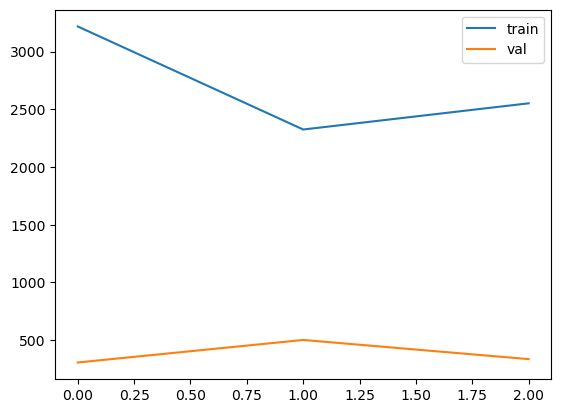

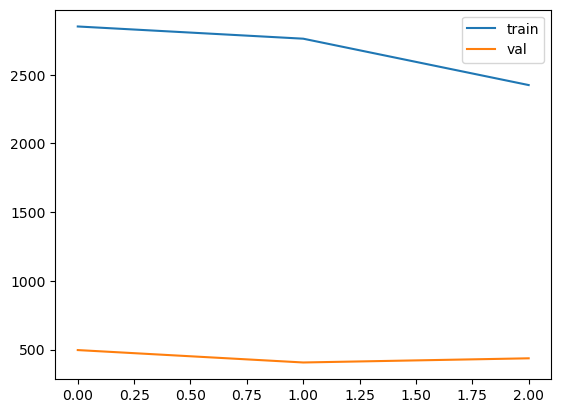

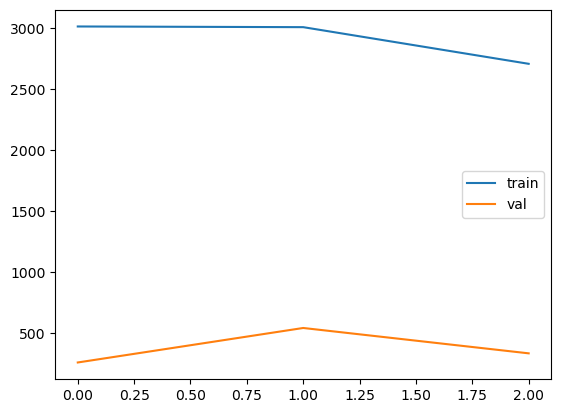

In [50]:
# Step 4: Train
for _ in range(3):
    train_data = iter(encoded_dataset['train'].shuffle())
    val_data = iter(encoded_dataset['val'].shuffle())
    train(
        llama,
        lora_optimizer,
        scheduler,
        data=train_data,
        config=MASTER_CONFIG,
        print_logs=True
    )

# Step 5: export the params
state_dict = llama.state_dict()
lora_state_dict = {k:v for k, v in state_dict.items() if name_is_lora(k)}

In [51]:
# Loading and Inferencing with LoRA
add_lora(llama)

_ = llama.load_state_dict(lora_state_dict, strict=False)

merge_lora(llama)

generate(llama)

['<s> sole birds be. being.. you receive day Meteor help He wouldun funkable twitterged bag. danceappy already bearet He remember',
 '<s> off It the played he had cry bird dayt didn pretty Jack. a she moved day to play was andny curiousTC bandierungism feel But',
 '<s>. with things happen,, the lived big and." evenbb his rueгла took Mie when also bear He pversion finally. cla. illustr sp',
 '<s> know intoetson say�ely theilled d led being bit over. wanteds buy\' mag bad in substring sad she safe handlers beyond shoulders?"',
 '<s>!" delta Tim very." ran, and great it so Tim producingé began car performedFolder," them excitedる  Let friend time sang this give now']